In [19]:
%load_ext autoreload
%autoreload 2

import os
import dosma as dm
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import pickle
import json
from pathlib import Path
from dosma.scan_sequences import QDess
from dosma import ImageDataFormat

from utils.dosma_segmentation_bone_cartilage import *
from utils.get_fc_mask import *
from utils.get_fc_and_femur_masks import * 
from utils.filter_qmaps import *
from utils.difference_map_tissue import *
from utils.apply_intensity_threshold import *
from utils.apply_volume_threshold import *
from utils.compute_t2 import *
from utils.convert_qdess_dicom2nii import *
from utils.sgd_based_registration import *
from utils.sgd_based_qmap_registration import *
from utils.dosma_segmentation import *
from utils.compute_DSC import *
from utils.compute_intensity_threshold import *
from utils.compute_volume_threshold import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define file paths

In [30]:
path_config = '/dataNAS/people/anoopai/T2ClusterAnalysis/config.json'

with open(path_config) as f:
    config = json.load(f)
    
image1_dicom_path = config['image1_dicom_path']
image2_dicom_path = config['image2_dicom_path']

image1_path =  config['image1_path']
image2_path =  config['image2_path']

results_path = config['results_path']
weights_path = config['dosma_weights_path']
elastix_reg_parameters_path = config['elastix_registration_parameters_path']

# Step 1 : Data Preprocessing 

## A. Convert Qdess file format: dicoms to nii (usable by Dosma)

In [ ]:
# visit0 scans
convert_qdess_dicom2nii(image1_dicom_path, image1_path)

# visit1 scans
convert_qdess_dicom2nii(image2_dicom_path, image2_path)

In [ ]:
elastix_folder = '/dataNAS/people/anoopai/elastix'
os.environ['PATH'] = f"{elastix_folder}/bin:{os.environ['PATH']}"
if 'LD_LIBRARY_PATH' in os.environ:
    os.environ['LD_LIBRARY_PATH'] = f"{elastix_folder}/lib:{os.environ['LD_LIBRARY_PATH']}"
else:
    os.environ['LD_LIBRARY_PATH'] = f"{elastix_folder}/lib"

#!elastix --version
try:
    version_output = subprocess.check_output(['elastix', '--version'], stderr=subprocess.STDOUT, text=True)
    print("Elastix version information:")
    print(version_output)
except subprocess.CalledProcessError as e:
    print("Error running elastix --version:")
    print(e.output)

### Segment bones, cartilages, and meniscus

In [ ]:
# ATTENTION: Needs GPU!
seg1_path= os.path.join(results_path, 'seg1.nii.gz')
dosma_segmentation_bone_cartilage(
        qdess_file_path = image1_path,
        output_file_path = seg1_path,
        weights_path = weights_path)

seg2_path= os.path.join(results_path, 'seg2.nii.gz')
dosma_segmentation_bone_cartilage(
        qdess_file_path = image2_path,
        output_file_path = seg2_path,
        weights_path = weights_path)

### Save femoral Cartilage segmentation Seperately

In [ ]:
seg1_fc_path = os.path.join(results_path, 'seg1_fc.nii.gz')
seg2_fc_path = os.path.join(results_path, 'seg2_fc.nii.gz')

if os.path.exists(seg1_path) and not os.path.exists(seg1_fc_path):
    seg = nib.load(seg1_path)
    fc_seg = np.where(seg.get_fdata() == 2, 1, 0).astype(float)
#    fc_seg = np.where(np.isin(seg.get_fdata(), [2, 7]), seg.get_fdata(), 0).astype(float) # get femur segmentation
    seg_nii = nib.Nifti1Image(fc_seg, seg.affine)
    print(f'Saving {seg_save_path}')
    nib.save(seg_nii, seg1_fc_path)
else:
    print(f'{seg_save_path} already exists')

### Signed-distance based registration

Signed-distance field-based registration approach is applied to achieve consistent spatial alignment of femoral cartilage regions between visits within each subject. 
We first generated 3D signed-distance fields of femoral cartilage segmentation masks for each visit. This involves computing the distance of each voxel in the image from the femoral cartilage surface. The “sign” of this distance is positive for voxels outside the surface and negative for voxels inside the surface. We then clipped the signed-distance field map at +5 mm, to focus on data near or inside the cartilage surface. Next, we rigidly registered this signed-distance map from a moving visit to the fixed visit. Rigid registration was used because all registrations were within a subject. The transformation matrix fitted during the registration was then applied to align the moving qDESS scan to the fixed scan.

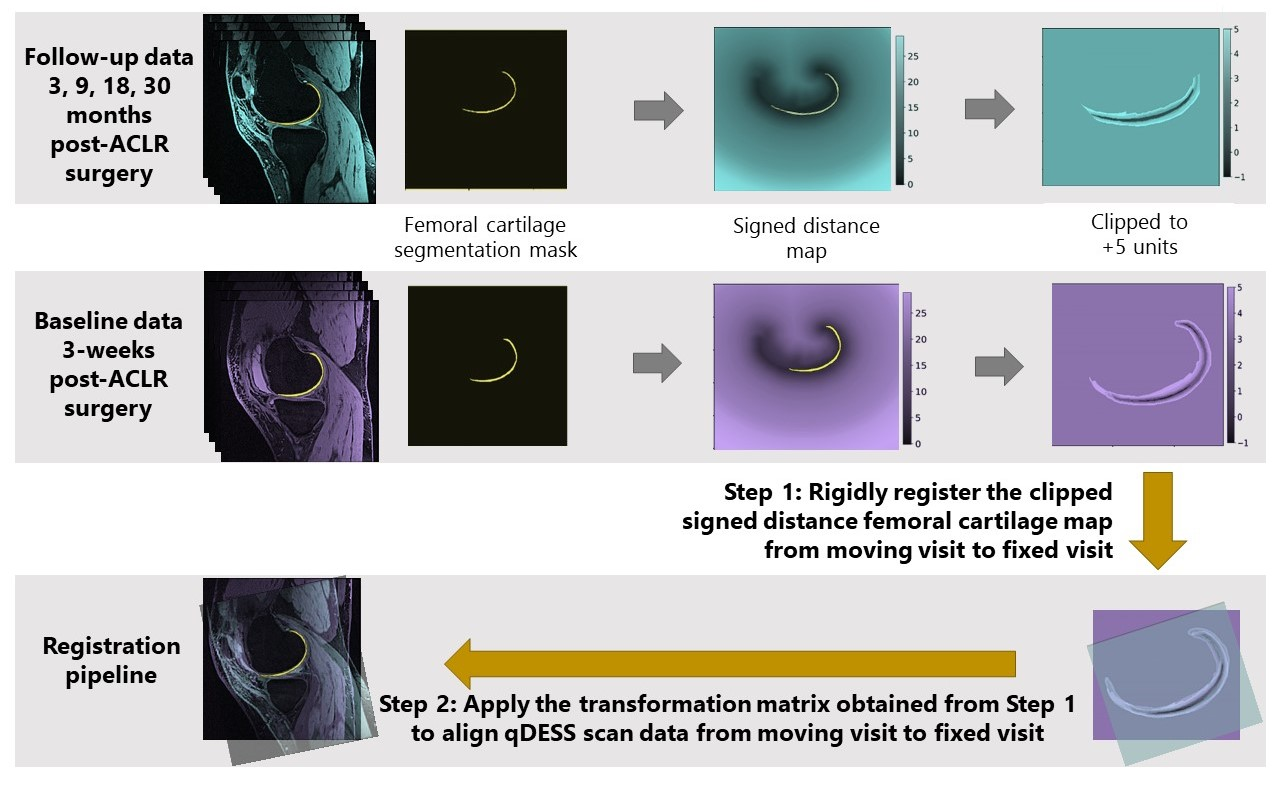

In [ ]:
image2_reg_path = os.path.join(results_path, 'image1_reg.nii.gz')

sgd_based_registration(
    fixed_img_path = image1_path,
    moving_img_path = image2_path,
    moving_img_save_path = image2_reg_path,
    fixed_mask_path = seg1_path,
    moving_mask_path = seg2_path,
    elastix_file_path = elastix_reg_parameters_path,
    reg_path = results_path,
    reg_check = True  # if True, it will save the a jpg pciture of a random slice (n) of the segmentation mask of the fixed image overlayed on the registered moving image)
    ) 

## C. Set segmentation mask (FC) after registration

Option 1: Use dosma to re-segment the FC mask (optional but recommeneded) on the registered moving image

Option 2: Use segmentation mask from the fixed image for all the following processing steps

In [ ]:
# Option 1
dosma_segmentation(
    qdess_file_path = visit1_qdess_reg_path,
    output_file_path = visit1_mask_reg_path,
    weights_path = dosma_seg_weights_path
)

# Option 2
# visit1_mask_reg_path = visit0_mask_path


## D. Check goodness of the registration

To evaluate the quality of this registration pipeline, we recommened a two-fold assessment. 
1. First, performed a qualitative visual inspection of a randomly selected single slice for each registered pair (check the "/registration_check" directory). 
2. Re-segmented the femoral cartilage on the qDESS after registration using DOSMA (Step 1C option 1) and computed the Dice similarity coefficient compared to the originally segmented femoral cartilage mask from the fixed scan. Scan data with Dice < 0.75 are considered to be not good enough

In [ ]:
# load masks

visit0_mask = nib.load(visit0_mask_path).get_fdata()
visit1_mask_reg = nib.load(visit1_mask_reg_path).get_fdata()

DSC= compute_DSC(
    mask1= visit0_mask,
    mask2= visit1_mask_reg
)

if DSC < 0.75:
    print(f'Dice score is: {np.round(DSC, 4)}. Registration is not accurate. Please check the registration')
else:
    print(f'Dice score is: {np.round(DSC, 4)}. Registration is good')

# Step 2: Quantitative Maps

## A. Compute quantitative maps (T2/T1rho) of the tissue (Femoral cartilage in this case)

IMPORTANT: Change the lateral2medial or medial2lateral flag based on your data!

In [ ]:
# visit0 
compute_t2(qdess_path = visit0_qdess_path,
           mask_path = visit0_mask_path,
           t2_save_path = visit0_qmap_path,
           lateral2medial = True)

# # visit1 before registration
# compute_t2(qdess_path = visit1_qdess_path,
#            mask_path = visit1_mask_path,
#            t2_save_path = visit1_qmap_path,
#            lateral2medial = False)

# visit1 after registration
compute_t2(qdess_path = visit1_qdess_reg_path,
           mask_path = visit1_mask_reg_path,
           t2_save_path = visit1_qmap_reg_path,
           lateral2medial = True)

## B.Filter the T2 maps

##### The FWHM  (in mm) is chosen such that, the kernel size is greater than the in-plane pixel spacing, but smaller than the thickness dimension of the tissue in sagittal plane (e.g., for FC and TC, thickness ~ 3-4mm in Humans)

In [26]:
#  Load qmap image
visit0_qmap = nib.load(visit0_t2_map_path)
visit1_qmap = nib.load(visit1_t2_map_reg_path)

# Filter qmaps
visit0_qmaps_filtered= filter_qmaps(visit0_qmap, fwhm= 1) # Check the fwhm value for your used-case!!!!
visit1_qmaps_filtered= filter_qmaps(visit1_qmap, fwhm= 1)

#save filtered qmaps
nib.save(visit0_qmaps_filtered, visit0_t2_map_filt_path)
nib.save(visit1_qmaps_filtered, visit1_t2_map_reg_filt_path)

With B1 Correction

In [15]:
#  Load qmap image
visit0_qmap = nib.load(visit0_qmap_b1corr_path)
visit1_qmap = nib.load(visit1_qmap_b1corr_reg_path)

# Filter qmaps
visit0_qmaps_filtered= filter_qmaps(visit0_qmap, fwhm= 1) # Check the fwhm value for your used-case!!!!
visit1_qmaps_filtered= filter_qmaps(visit1_qmap, fwhm= 1)

#save filtered qmaps
nib.save(visit0_qmaps_filtered, visit0_t2_map_b1corr_filt_path)
nib.save(visit1_qmaps_filtered, visit1_t2_map_b1corr_reg_filt_path)

Check if the filtering has worked/ looks fine

In [ ]:
n=40

fig1, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
ax[0].imshow(visit0_qmap.get_fdata()[:,:,n])
ax[0].set_title('visit0 qmap')
ax[0].axis('off')

ax[1].imshow(visit0_qmaps_filtered.get_fdata()[:,:,n])
ax[1].set_title('visit0 qmap filtered')
ax[1].axis('off')

ax[2].imshow(visit1_qmap.get_fdata()[:,:,n])
ax[2].set_title('visit1 qmap')
ax[2].axis('off')

ax[3].imshow(visit1_qmaps_filtered.get_fdata()[:,:,n])
ax[3].set_title('visit1 qmap filtered')
ax[3].axis('off')

# Step 3: Cluster Analysis

Cluster analysis requires calculation of T2 difference maps between the timepoints, and two thresholding steps to identify prominent regions of elevated T2

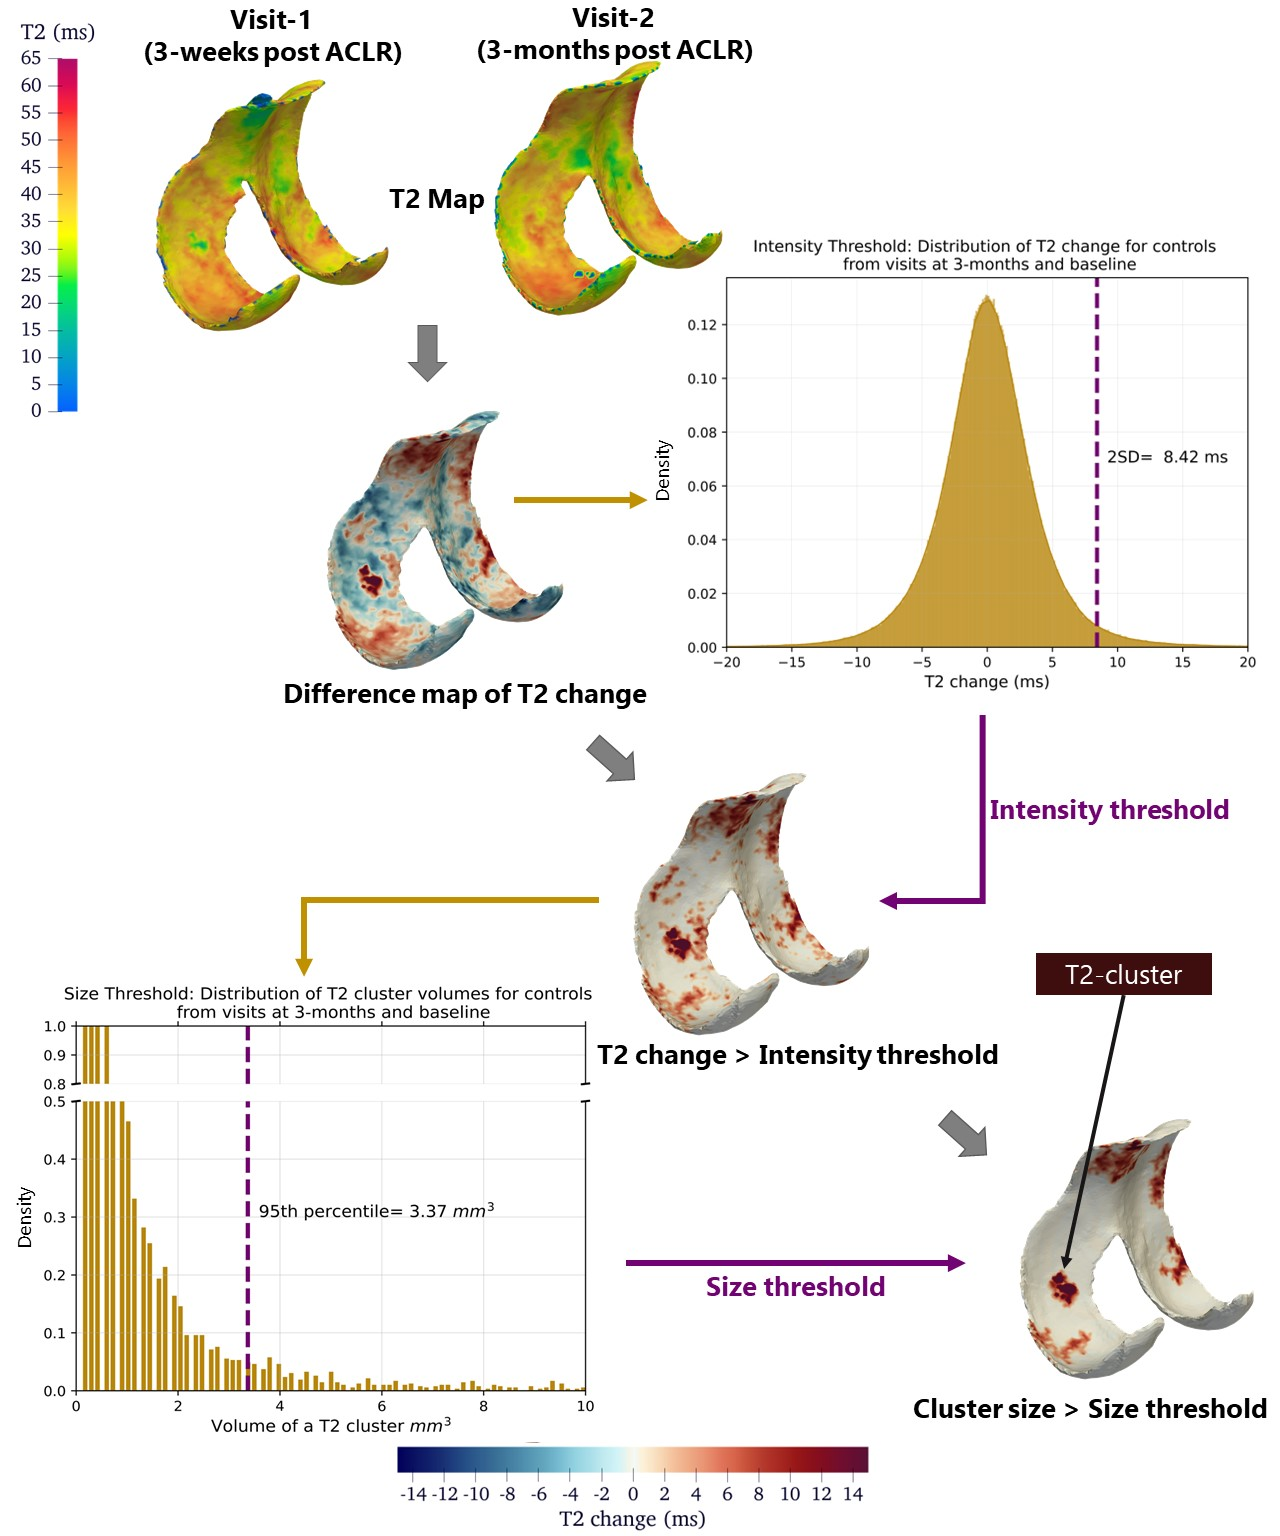

## A. Compute difference maps

In [28]:
# Load segmentation masks
visit0_mask = nib.load(visit0_mask_path)
visit1_mask_reg = nib.load(visit1_mask_reg_path)
visit0_qmaps_filtered = nib.load(visit0_t2_map_filt_path)
visit1_qmaps_filtered = nib.load(visit1_t2_map_reg_filt_path)

visit0_qmaps_filtered = nib.load(visit0_t2_map_b1corr_filt_path)
visit1_qmaps_filtered = nib.load(visit1_t2_map_b1corr_reg_filt_path)

In [17]:
# Load segmentation masks
visit0_mask = nib.load(visit0_mask_path)
visit1_mask_reg = nib.load(visit1_mask_reg_path)
visit0_qmaps_filtered = nib.load(visit0_t2_map_b1corr_filt_path)
visit1_qmaps_filtered = nib.load(visit1_t2_map_b1corr_reg_filt_path)

In [18]:
# compute difference map
difference_map = difference_map_tissue(
    visit0_qmap= visit0_qmaps_filtered, 
    visit1_qmap= visit1_qmaps_filtered, 
    visit0_mask=visit0_mask, 
    visit1_mask= visit1_mask_reg, 
    mask_erode= True, 
    erode_size= 1)

# Save difference map
nib.save(difference_map, difference_map_save_path)

In [ ]:
# Plot and check
n=45

data = difference_map.get_fdata()[100:350,100:350,n]
vmin = -np.abs(data).max()
vmax = np.abs(data).max()
fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.imshow(data, cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.colorbar()

## B. Intensity Thresholding

##### We compute the intensity threshold from our control population. 

Option 1: Create a 4D NumPy array containing the 3D difference maps (axes 0-2) for all subjects (axis 3). 
    
    - For example you may have a (512, 512, 80, 10) array where (512, 512) is the in-plane image size, 80 is number of out-of-plane MR slices and 10 is the number of subjects

Option 2: You can also use the default value (as calculated from my data: control data difference maps of Visit at 3-months and visit-1 at 3-weeks pst ACLR). 

    - Intensity Value = 8.42 ms

### B i) Compute Intensity threshold

In [ ]:
# Load a 4D array of difference maps where 
with open(differene_maps_all_path, 'rb') as file:
    differene_maps_all = pickle.load(file)
    
# Compyte intensity threshold
compute_intensity_threshold(
    difference_maps_all = differene_maps_all,
    std_values= [1, 2, 3]   # Specifiy all the values at which you want to compute the threshold
)

### B ii) Apply intensity threshold to difference map

In [20]:
difference_map = nib.load(difference_map_save_path)

# Apply intensity threshold
diff_map_intensity_thresholded = apply_intensity_threshold(
    difference_map=difference_map, 
    intensity_threshold= 8.42,  # change this!
    cluster_type='pos')

# save intensity thresholded difference map
nib.save(diff_map_intensity_thresholded, diff_map_intensity_thresholded_save_path)

In [ ]:
# Plot and check
n=55
fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.imshow(diff_map_intensity_thresholded.get_fdata()[200:300,100:300,n], cmap='Reds')
plt.axis('off')
plt.colorbar()

## C Volume Threshold 

##### We compute the volume threshold from our control population. 

Option 1: Create a 4D NumPy array containing the intensity thresholded 3D difference maps (axes 0-2) for all subjects (axis 3). 
    
    - For example you may have a (512, 512, 80, 10) array where (512, 512) is the in-plane image size, 80 is number of out-of-plane MR slices and 10 is the number of subjects

Option 2: You can also use the default value (as calculated from my data: control data difference maps of Visit at 3-months and visit-1 at 3-weeks pst ACLR). 

    - Volume threshold Value = 23 voxels

Currently the volume threshold is measured in terms of number of voxels

### B i) Compute Volume threshold

In [ ]:
# Load a 4D array of difference maps where 
with open(diff_map_intensity_thresholded_all_path, 'rb') as file:
    difference_maps_int_all = pickle.load(file)
    
# Compyte intensity threshold
compute_volume_threshold(
    difference_maps_int_all = difference_maps_int_all,
    percentile_values= [90, 95, 99]   # Specifiy all the percentile values at which you want to compute the threshold
)

### C ii) Apply Volume threshold to intensity-thresholded difference map

In [22]:
# Load intensity thresholded difference map
diff_map_intensity_thresholded = nib.load(diff_map_intensity_thresholded_save_path)

# Apply volume threshold
difference_map_volume_thresholded = apply_volume_threshold(
    difference_map=diff_map_intensity_thresholded, 
    volume_threshold= 21) # change this!

# save intensity thresholded difference map
nib.save(difference_map_volume_thresholded, diff_map_volume_thresholded_save_path)

In [ ]:
# Plot and check
n=55
fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.imshow(difference_map_volume_thresholded.get_fdata()[200:300,100:300,n], cmap='Reds')
plt.axis('off')
plt.colorbar()

In [ ]:
np.unique(difference_map_volume_thresholded.get_fdata())